### NOTE: If running from colab and you have uploaded the folder ERA-V1/era_v1_session7_pankaja then uncomment the two cells below and run before moving on to Install libraries

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# %cd /gdrive/My\ Drive/ERA-V1/era_v1_session7_pankaja

/gdrive/My Drive/ERA-V1/era_v1_session7_pankaja


### Target:

- Establish the basic skeleton in terms of convolution and placement of transition blocks such as max pooling, 1x1's
- Attempting to reduce the number of parameters as low as possible
- Adding GAP and remove the last BIG kernel.

### Results:
- Total parameters: 4572
- Best Training accuracy: 98.22
- Best Test accuracy: 98.43

### Analysis:
- Structured the model as a new model class
- The model is lighter with less number of parameters
- The performace is reduced compared to previous models. Since we have reduced model capacity, this is expected, the model has capability to learn.
- Next, we will be tweaking this model further and increase the capacity to push it more towards the desired accuracy.

# Install Libraries

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm import tqdm
from torchsummary import summary

# for visualization
%matplotlib inline
import matplotlib.pyplot as plt

from model import Model_2, download_model_data, create_data_loader, train_and_predict
from utils import get_device, plot_metrics

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)


## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

Data tasks:
- transformers
- data download
- train and test split

In [ ]:
ds_train, ds_test = download_model_data()
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
kw_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(ds_train, **kw_args)
test_loader = torch.utils.data.DataLoader(ds_test, **kw_args)


CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


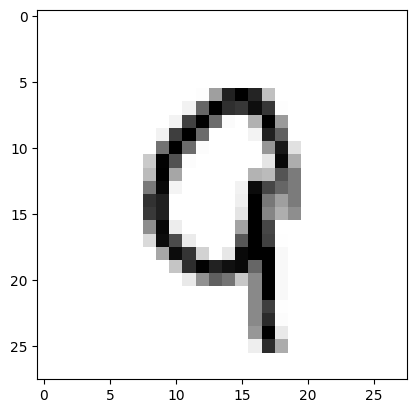

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = ds_train.train_data
train_data = ds_train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', ds_train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', ds_train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

# create an iter
images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)

# visualize
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

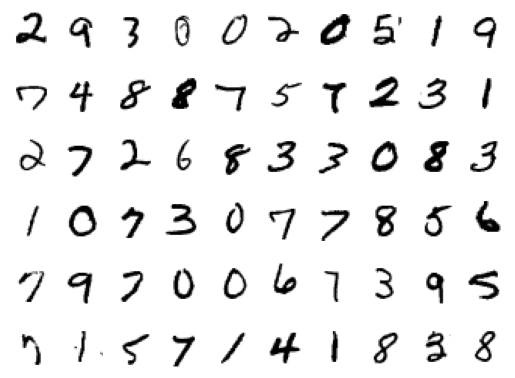

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model_2

### Model_2 summary

In [ ]:
# get device and load Model_2
device = get_device()
print(device)
model = Model_2().to(device)
summary(model, input_size=(1, 28, 28))

CUDA Available? True
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]             128
              ReLU-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 10, 10, 10]             720
              ReLU-9           [-1, 10, 10, 10]               0
           Conv2d-10             [-1, 10, 8, 8]             900
             ReLU-11             [-1, 10, 8, 8]               0
           Conv2d-12             [-1, 16, 6, 6]           1,440
             ReLU-13             [-1, 16, 6, 6]               0
           Co

### Train and test -  Model_2

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)

# load model to device and start the training
model = Model_2().to(device)
epochs = 15
lr = 0.01
train_losses2, train_acc2, test_losses2, test_acc2 = train_and_predict(model, device,
                                                                   train_loader=train_loader,
                                                                   test_loader=test_loader,
                                                                   num_epochs=epochs, lr=lr)

CUDA Available? True
Epoch 1


Train: Loss=2.2267 Batch_id=468 Accuracy=8.68: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]


Test set: Average loss: 2.2001, Accuracy: 1406/10000 (14.06%)

Epoch 2


Train: Loss=0.3996 Batch_id=468 Accuracy=72.45: 100%|██████████| 469/469 [00:18<00:00, 25.95it/s]


Test set: Average loss: 0.4811, Accuracy: 8458/10000 (84.58%)

Epoch 3


Train: Loss=0.2512 Batch_id=468 Accuracy=91.38: 100%|██████████| 469/469 [00:18<00:00, 24.71it/s]


Test set: Average loss: 0.1831, Accuracy: 9455/10000 (94.55%)

Epoch 4


Train: Loss=0.1296 Batch_id=468 Accuracy=94.16: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]


Test set: Average loss: 0.1370, Accuracy: 9586/10000 (95.86%)

Epoch 5


Train: Loss=0.1499 Batch_id=468 Accuracy=95.42: 100%|██████████| 469/469 [00:18<00:00, 25.84it/s]


Test set: Average loss: 0.1343, Accuracy: 9630/10000 (96.30%)

Epoch 6


Train: Loss=0.2958 Batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]


Test set: Average loss: 0.1730, Accuracy: 9453/10000 (94.53%)

Epoch 7


Train: Loss=0.0829 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]


Test set: Average loss: 0.0965, Accuracy: 9719/10000 (97.19%)

Epoch 8


Train: Loss=0.0214 Batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]


Test set: Average loss: 0.0942, Accuracy: 9722/10000 (97.22%)

Epoch 9


Train: Loss=0.0212 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]


Test set: Average loss: 0.0928, Accuracy: 9715/10000 (97.15%)

Epoch 10


Train: Loss=0.0418 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:19<00:00, 23.75it/s]


Test set: Average loss: 0.0849, Accuracy: 9714/10000 (97.14%)

Epoch 11


Train: Loss=0.0284 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]


Test set: Average loss: 0.0709, Accuracy: 9777/10000 (97.77%)

Epoch 12


Train: Loss=0.0389 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s]


Test set: Average loss: 0.0638, Accuracy: 9803/10000 (98.03%)

Epoch 13


Train: Loss=0.0715 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]


Test set: Average loss: 0.0580, Accuracy: 9806/10000 (98.06%)

Epoch 14


Train: Loss=0.0234 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]


Test set: Average loss: 0.0724, Accuracy: 9780/10000 (97.80%)

Epoch 15


Train: Loss=0.0788 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]


Test set: Average loss: 0.0551, Accuracy: 9819/10000 (98.19%)



**Plot the train and test losses and accuracies for Model_2**

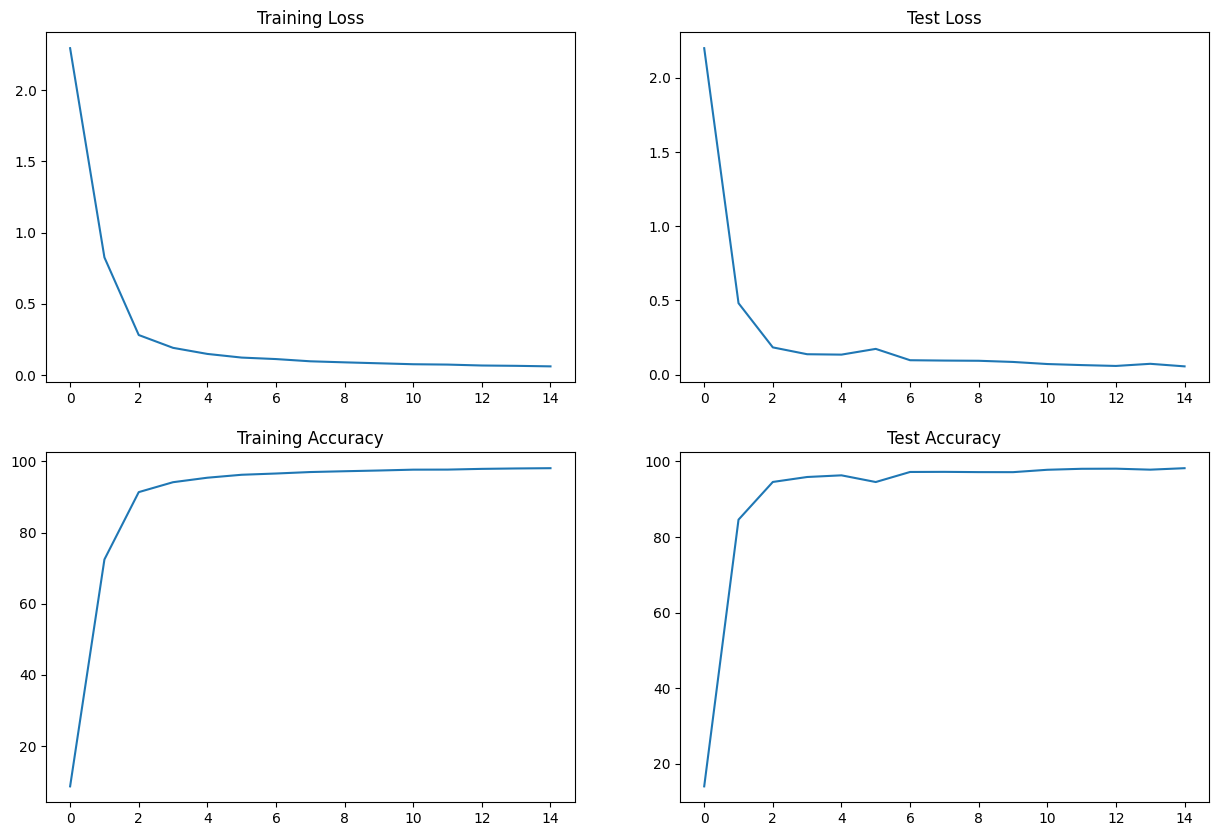

In [ ]:
plot_metrics(train_losses2, train_acc2, test_losses2, test_acc2)